In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

19373.35316439481 10252.823673669911
6363.160053871303 m 3364.151974245151 m
-1.8939052602849715
-1.6846475229738072 m


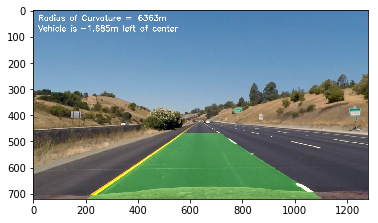

array([[[ 84, 138, 185],
        [ 85, 139, 186],
        [ 85, 139, 186],
        ...,
        [ 72, 130, 178],
        [ 73, 131, 179],
        [ 74, 132, 180]],

       [[ 85, 137, 185],
        [ 86, 138, 186],
        [ 86, 138, 186],
        ...,
        [ 72, 130, 178],
        [ 73, 131, 179],
        [ 74, 132, 180]],

       [[ 85, 137, 185],
        [ 85, 137, 185],
        [ 86, 138, 186],
        ...,
        [ 73, 131, 177],
        [ 73, 131, 178],
        [ 73, 131, 177]],

       ...,

       [[ 95,  83,  99],
        [ 95,  83,  99],
        [ 96,  83,  99],
        ...,
        [118,  97,  93],
        [116,  96,  91],
        [114,  94,  90]],

       [[ 96,  84,  98],
        [ 96,  84,  98],
        [ 96,  84,  98],
        ...,
        [116,  95,  90],
        [118,  97,  92],
        [116,  95,  90]],

       [[ 96,  84,  96],
        [ 96,  84,  96],
        [ 97,  85,  97],
        ...,
        [115,  94,  91],
        [117,  96,  92],
        [116,  95,  91]]

In [36]:
def findLines(img):
    # img = mpimg.imread('test_images/test1.jpg')

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    top_left = [570,470]
    top_right = [720,470]
    bottom_right = [1130,720]
    bottom_left = [200,720]
    pts = np.array([bottom_left,bottom_right,top_right,top_left])

    top_left_dst = [320,0]
    top_right_dst = [980,0]
    bottom_right_dst = [980,720]
    bottom_left_dst = [320,720]
    dst_pts = np.array([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst])

    ## you can plot this and see that lines are properly chosen
    # cv2.polylines(img,[pts],True,(255,0,0), 5)
    # cv2.polylines(img,[dst_pts],True,(0,0,255), 5)

    src = np.float32(pts.tolist())
    dst = np.float32(dst_pts.tolist())

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])

    binary_warped = cv2.warpPerspective(combined_binary, M, img_size , flags=cv2.INTER_LINEAR)
    # binary_warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)

    # # Plotting thresholded images
    # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    # ax1.set_title('Original Image')
    # ax1.imshow(img)
    #
    # ax2.set_title('Birds-eye-view')
    # ax2.imshow(binary_warped, cmap='gray')
    # plt.show()

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    # Vehicle position with respect to center   
    #calculate the x position for y at the height of the image for left lane
    left_lane_bottom = left_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + left_fit_cr[1] * (y_eval * ym_per_pix) + \
                        left_fit_cr[2]

    #calculate the x position for y at the height of the image for right lane                   
    right_lane_bottom = right_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + right_fit_cr[1] * (y_eval * ym_per_pix) + \
                         right_fit_cr[2]

    #calculate the mid point of identified lane
    lane_midpoint = float(right_lane_bottom - left_lane_bottom) / 2

    #calculate the image center in meters from left edge of the image to right edge of image
    image_mid_point_in_meter = lane_midpoint * xm_per_pix;

    lane_deviation = (image_mid_point_in_meter - lane_midpoint)
    
    print(image_mid_point_in_meter - img.shape[0]*xm_per_pix/2)
    
    print(lane_deviation, 'm')

    # out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # plt.imshow(out_img)
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    # plt.xlim(0, 1280)
    # plt.ylim(720, 0)
    # plt.show()

    pickle_data = pickle.load(open('wide_dist_pickle.p', 'rb'))
    mtx = pickle_data["mtx"]
    dist = pickle_data["dist"]

    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,"Radius of Curvature = ",(20,40), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result,str(int(left_curverad)) + "m",(400,40), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result,"Vehicle is ",(20,80), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result,str(round(lane_deviation, 3)) + "m left of center",(180,80), font, 1, (255,255,255), 2, cv2.LINE_AA)

    plt.imshow(result)
    plt.show()
    return result

img = mpimg.imread('test_images/straight_lines1.jpg')

findLines(img)

3725.330536664163 7767.579291762765
1223.4134006657819 m 2540.0982730987216 m
-1.8936119691664546
-1.7398417407638838 m


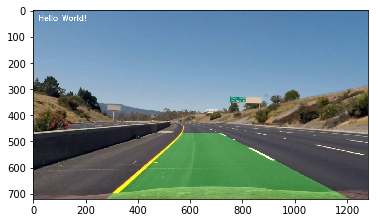

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


  0%|          | 0/126 [00:00<?, ?it/s]

3725.330536664163 7767.579291762765
1223.4134006657819 m 2540.0982730987216 m
-1.8936119691664546
-1.7398417407638838 m


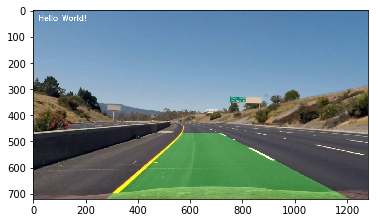

  1%|          | 1/126 [00:00<00:54,  2.30it/s]

3552.818235529139 54026.57796025885
1166.9008289185797 m 17499.30082323272 m
-1.8935779852308952
-1.7462371500422575 m


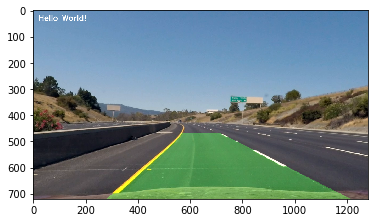

  2%|▏         | 2/126 [00:00<00:53,  2.30it/s]

3195.7159152119802 29138.485655800443
1049.6034715147814 m 9446.36563503441 m
-1.8936021801438558
-1.741683928989681 m


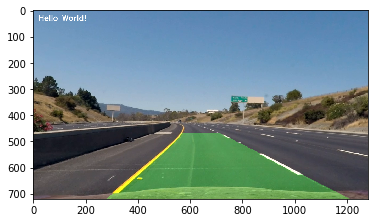

  2%|▏         | 3/126 [00:01<00:51,  2.37it/s]

2822.570401407037 21446.491432044713
926.5948290469585 m 6895.498093553415 m
-1.8935886683703382
-1.7442266986924706 m


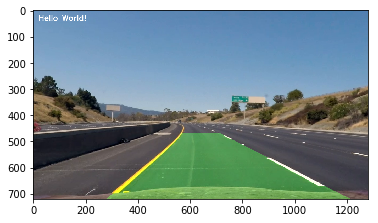

  3%|▎         | 4/126 [00:01<00:49,  2.46it/s]

3351.752410089826 3251.671897107523
1100.796654081722 m 1067.7696312267535 m
-1.8937789020195723
-1.7084267824866257 m


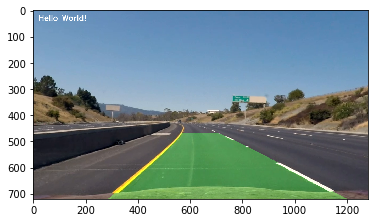

  4%|▍         | 5/126 [00:01<00:47,  2.54it/s]

3731.443007918389 5194.036506290484
1224.7738982363667 m 1698.7663109068403 m
-1.8937852757030023
-1.70722732416977 m


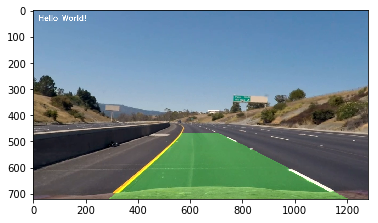

  5%|▍         | 6/126 [00:02<00:44,  2.68it/s]

3961.9332164080265 4482.231526550432
1299.3486687693603 m 1468.4907720178082 m
-1.893822667454279
-1.7001906008146528 m


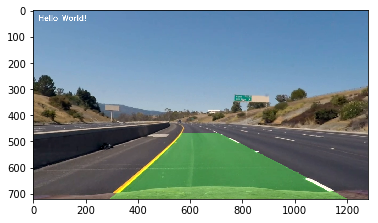

  6%|▌         | 7/126 [00:02<00:42,  2.79it/s]

4003.246638772754 3532.1443292778285
1312.531207829498 m 1159.5844274775495 m
-1.893958709926752
-1.6745888782246716 m


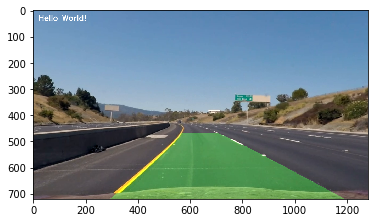

  6%|▋         | 8/126 [00:03<00:42,  2.75it/s]

3986.524399427033 2547.3319046855586
1306.4528410942623 m 836.0300845854063 m
-1.8940154651970713
-1.663908149921072 m


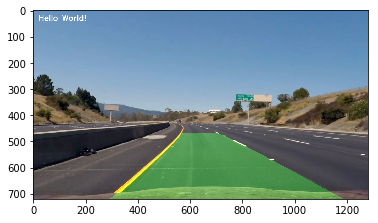

  7%|▋         | 9/126 [00:03<00:42,  2.75it/s]

3933.5322332843816 2185.3892929768253
1288.787789920277 m 715.9404005693114 m
-1.894042245065427
-1.6588684682085846 m


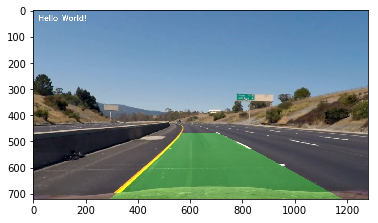

  8%|▊         | 10/126 [00:03<00:43,  2.69it/s]

3589.6084241410417 4407.850210985619
1176.638122881685 m 1439.0457947541722 m
-1.8937824030856927
-1.707767919692142 m


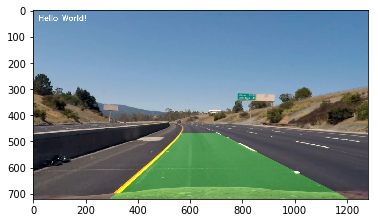

  9%|▊         | 11/126 [00:04<00:43,  2.66it/s]

3585.6715825473616 3975.3031376225067
1174.0415202434576 m 1303.7297271315767 m
-1.893802130403353
-1.7040554517767368 m


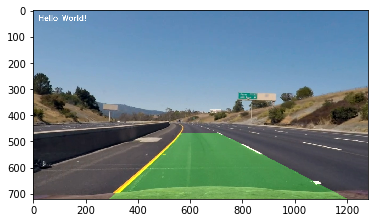

 10%|▉         | 12/126 [00:04<00:43,  2.65it/s]

3582.654972600085 7566.798521189469
1172.912087430726 m 2457.732208909607 m
-1.893693185985265
-1.7245576134833995 m


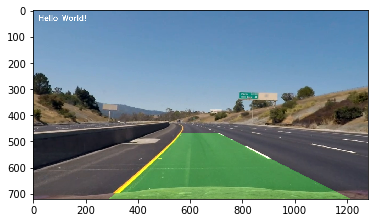

 10%|█         | 13/126 [00:04<00:44,  2.56it/s]

3641.7054191060006 8577.942776854885
1191.0985054442483 m 2673.1193384788417 m
-1.8935345554311191
-1.7544101688487614 m


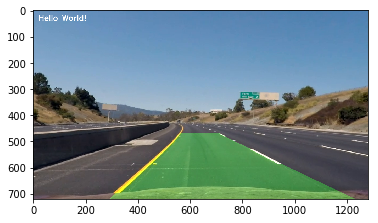

 11%|█         | 14/126 [00:05<00:43,  2.57it/s]

3748.2965952812287 11244.488719395946
1226.1700883319538 m 3521.420505613151 m
-1.8936489253667046
-1.7328869834032992 m


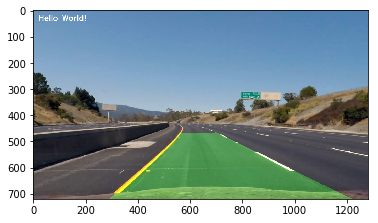

 12%|█▏        | 15/126 [00:05<00:42,  2.58it/s]

4315.0661598787965 12273.228338060439
1408.8790047927434 m 3852.464462583958 m
-1.893779714189369
-1.708273940911101 m


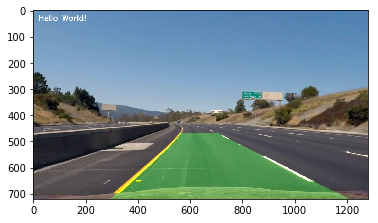

 13%|█▎        | 16/126 [00:06<00:42,  2.61it/s]

4842.383174261129 6805.9028266272735
1578.0511046971749 m 2200.398337030468 m
-1.8939102643802752
-1.6837058063359662 m


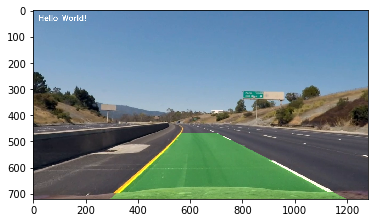

 13%|█▎        | 17/126 [00:06<00:42,  2.59it/s]

6145.9779277899925 13138.600982670301
1994.8588825173608 m 4213.9055937686535 m
-1.8939380477793117
-1.6784772709983526 m


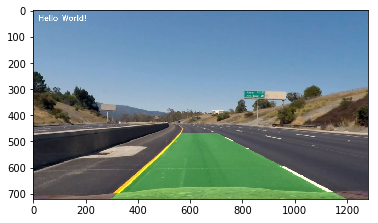

 14%|█▍        | 18/126 [00:06<00:41,  2.58it/s]

6212.432703148727 56244.6710188764
2015.2324431177612 m 17996.93150727159 m
-1.893905003795247
-1.6846957915670835 m


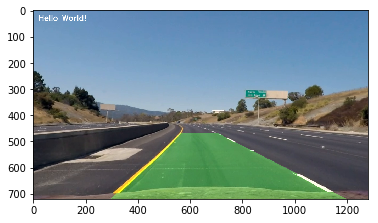

 15%|█▌        | 19/126 [00:07<00:39,  2.70it/s]

6440.226769940758 7533.415725453844
2085.2984922021537 m 2454.2938601859832 m
-1.8940487484563275
-1.6576446003480723 m


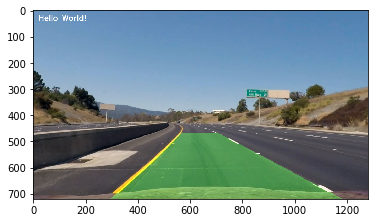

 16%|█▌        | 20/126 [00:07<00:39,  2.68it/s]

9287.443426466063 5168.985095327015
2990.2171312674905 m 1693.9665550695654 m
-1.8941004713777394
-1.6479109057050765 m


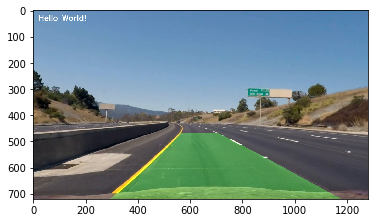

 17%|█▋        | 21/126 [00:07<00:39,  2.63it/s]

9154.131868878545 3495.25347267454
2947.6901251146783 m 1147.9994062760836 m
-1.8941079460133348
-1.646504260092878 m


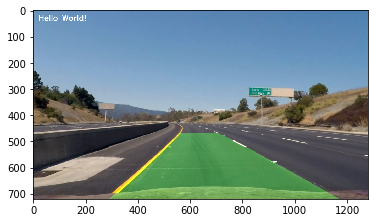

 17%|█▋        | 22/126 [00:08<00:39,  2.65it/s]

30899.13688250365 2297.5657655175773
9864.222192679048 m 751.0710885966295 m
-1.894174999582852
-1.6338855032131778 m


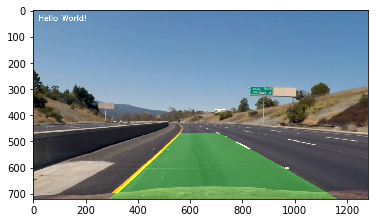

 18%|█▊        | 23/126 [00:08<00:38,  2.65it/s]

13815.713630167798 3736.9737884407227
4444.159690226164 m 1226.6963814810722 m
-1.89395274371082
-1.6757116555634552 m


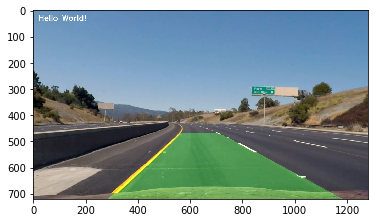

 19%|█▉        | 24/126 [00:09<00:40,  2.50it/s]

8166.382175021177 3987.9436071653395
2646.3609130068694 m 1308.040432090252 m
-1.893885076949725
-1.688445808468946 m


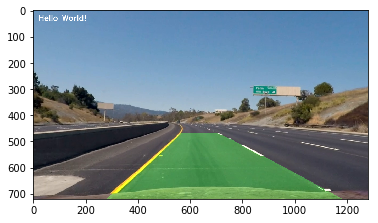

 20%|█▉        | 25/126 [00:09<00:39,  2.59it/s]

7210.493673081158 4379.546380751796
2338.6575786891567 m 1436.769787337093 m
-1.893814056429216
-1.7018111026393485 m


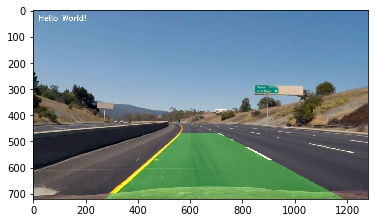

 21%|██        | 26/126 [00:09<00:38,  2.60it/s]

6039.609556541975 13941.017018758377
1965.309457854157 m 4529.047980302115 m
-1.8936431304881816
-1.7339775168939993 m


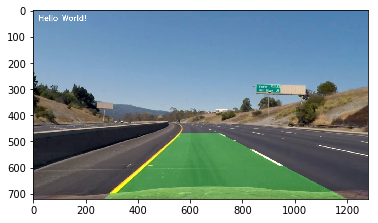

 21%|██▏       | 27/126 [00:10<00:38,  2.60it/s]

5418.722474753611 42908.99033592066
1766.6020691531528 m 13936.832609110952 m
-1.8935580027685837
-1.749997633422685 m


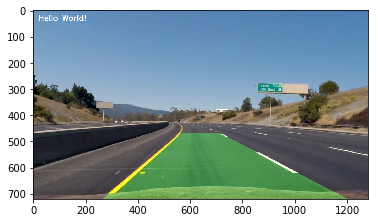

 22%|██▏       | 28/126 [00:10<00:36,  2.65it/s]

5582.714178272247 47566.356389434266
1820.8208762429492 m 15440.927504185014 m
-1.8935905221014027
-1.7438778465464706 m


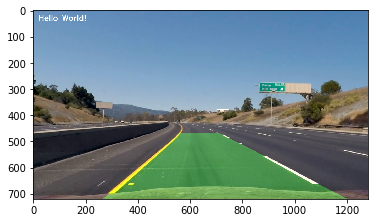

 23%|██▎       | 29/126 [00:11<00:36,  2.63it/s]

5243.109179658195 16446.42802150507
1713.21891955117 m 5350.093367897039 m
-1.8936339791984034
-1.735699690697406 m


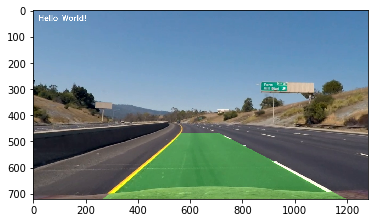

 24%|██▍       | 30/126 [00:11<00:36,  2.66it/s]

5252.566919565036 5129.3750794613015
1717.2675729751095 m 1678.2458894418157 m
-1.8936843251483149
-1.726225127204612 m


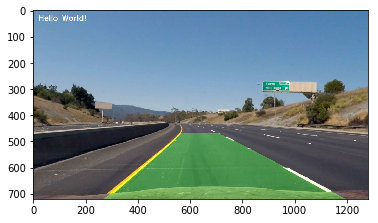

 25%|██▍       | 31/126 [00:11<00:35,  2.71it/s]

4634.846157804261 6514.661564961106
1518.5861496367154 m 2123.6413977798265 m
-1.8937006900923998
-1.723145421646144 m


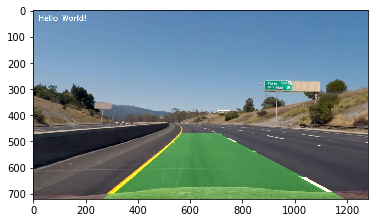

 25%|██▌       | 32/126 [00:12<00:34,  2.69it/s]

4953.272849428034 4915.083864454411
1621.9935972226776 m 1610.3642753144145 m
-1.89373779641724
-1.7161624124606736 m


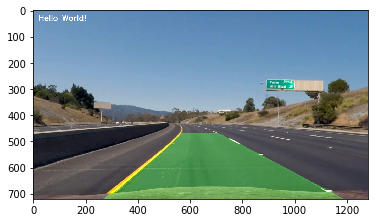

 26%|██▌       | 33/126 [00:12<00:34,  2.72it/s]

3985.041478180313 2689.563427336139
1307.3198929005953 m 882.7493074024462 m
-1.8939012789961829
-1.6853967584828613 m


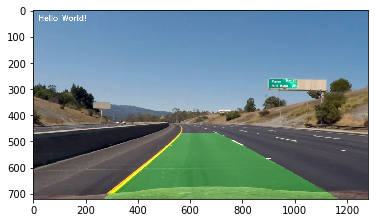

 27%|██▋       | 34/126 [00:12<00:33,  2.75it/s]

5569.786864070947 1901.7653071268642
1822.6584109060866 m 620.5668979826632 m
-1.894030515423552
-1.6610758600025461 m


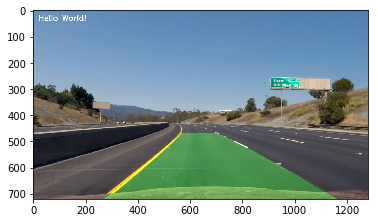

 28%|██▊       | 35/126 [00:13<00:34,  2.63it/s]

4414.169961447867 2643.3436147592033
1447.5865402794968 m 868.2148344428454 m
-1.8938856252215797
-1.6883426296331747 m


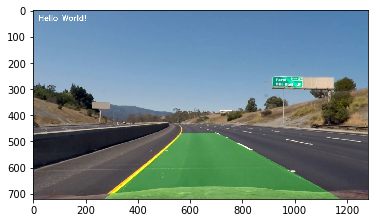

 29%|██▊       | 36/126 [00:13<00:33,  2.66it/s]

3713.663792054042 3486.6226256312866
1219.1500559096626 m 1142.239640939845 m
-1.8937820928758524
-1.7078262978304612 m


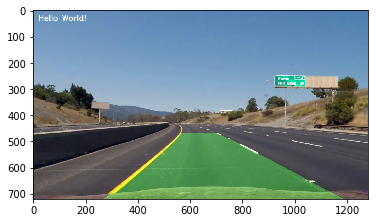

 29%|██▉       | 37/126 [00:14<00:33,  2.70it/s]

3329.807306089149 9310.35566876763
1093.6262811269053 m 2995.0773047947287 m
-1.8936220877576107
-1.7379375312984668 m


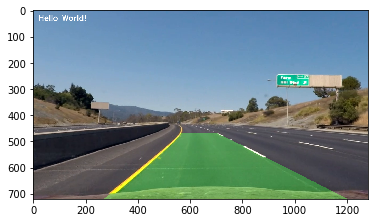

 30%|███       | 38/126 [00:14<00:32,  2.75it/s]

2917.5708882020426 31107.379540109963
958.2376143766129 m 9868.283671518575 m
-1.8936007258897307
-1.7419576038943598 m


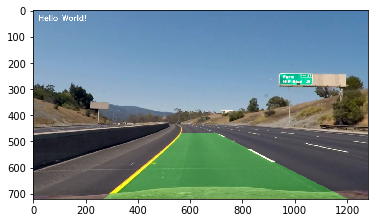

 31%|███       | 39/126 [00:14<00:30,  2.83it/s]

2936.4005140470294 13682.89523830788
964.469999889397 m 4386.321625869331 m
-1.893670165980684
-1.728889729480624 m


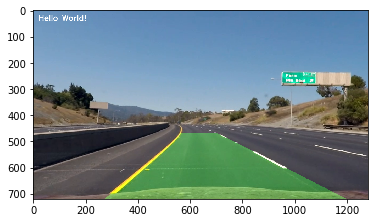

 32%|███▏      | 40/126 [00:15<00:30,  2.79it/s]

2901.4985809513228 18885.53694377134
953.006990646421 m 6046.634267598701 m
-1.893690148771033
-1.725129184367163 m


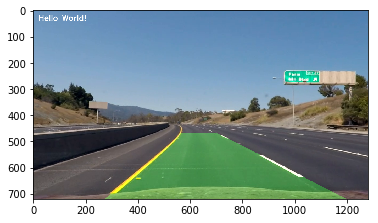

 33%|███▎      | 41/126 [00:15<00:30,  2.77it/s]

2948.9333436517004 6404.047315638909
968.5244272988049 m 2076.517170828729 m
-1.8937628199610932
-1.7114532520323005 m


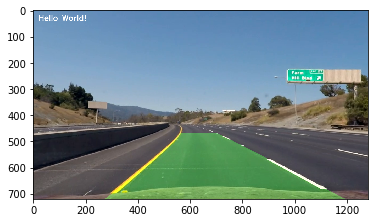

 33%|███▎      | 42/126 [00:15<00:30,  2.76it/s]

3161.2352744007735 4044.2142293872357
1037.6064927201962 m 1320.820159749579 m
-1.8938160076113755
-1.7014439112508104 m


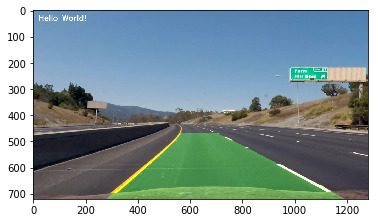

 34%|███▍      | 43/126 [00:16<00:30,  2.70it/s]

3088.220531842191 7231.1758980585
1013.5774911670271 m 2350.864080010034 m
-1.8937744925100393
-1.7092566045103776 m


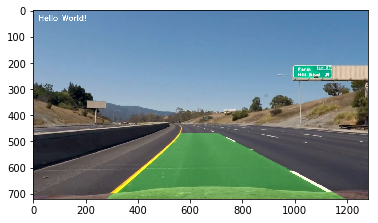

 35%|███▍      | 44/126 [00:16<00:29,  2.77it/s]

3215.926474276509 6436.364179324364
1054.7125357073255 m 2098.240263979654 m
-1.893787874931364
-1.7067381774919057 m


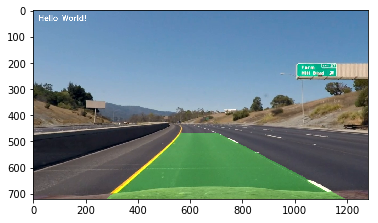

 36%|███▌      | 45/126 [00:16<00:28,  2.82it/s]

2881.2563543984293 4399.4495080639845
945.5956984378744 m 1442.1183049311014 m
-1.8938809326922206
-1.6892257129285024 m


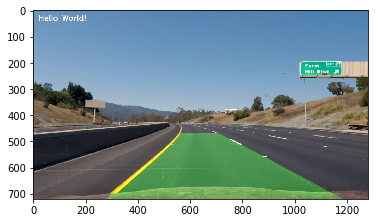

 37%|███▋      | 46/126 [00:17<00:30,  2.64it/s]

3219.720693800093 2592.7500985995225
1055.4418307799506 m 850.9807989654787 m
-1.8939924023266037
-1.668248332814724 m


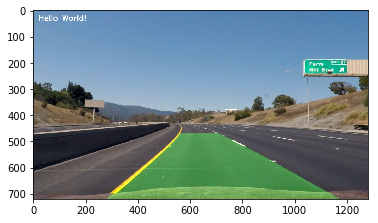

 37%|███▋      | 47/126 [00:17<00:28,  2.72it/s]

3600.4086042494955 1951.6343871297113
1178.4759804553883 m 638.2608046843062 m
-1.8940858758774295
-1.6506576210742092 m


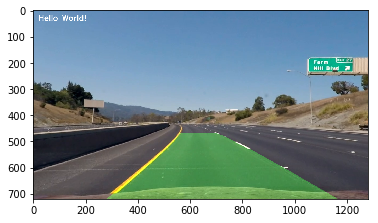

 38%|███▊      | 48/126 [00:17<00:27,  2.79it/s]

3510.9706140107232 2507.028171285695
1148.779989540169 m 823.0628309149301 m
-1.89394665780174
-1.6768569578586643 m


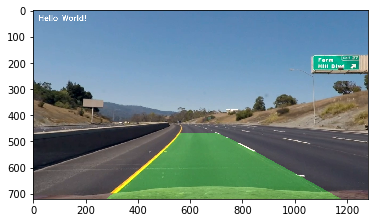

 39%|███▉      | 49/126 [00:18<00:27,  2.82it/s]

3174.669145393001 3173.5329881949415
1039.6508942621556 m 1041.2272446671598 m
-1.8938309058018825
-1.6986402328588868 m


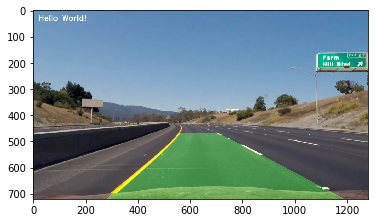

 40%|███▉      | 50/126 [00:18<00:27,  2.77it/s]

3174.7585085434116 4295.789845888685
1039.2093177975778 m 1402.972899264982 m
-1.893762943817428
-1.7114299436090759 m


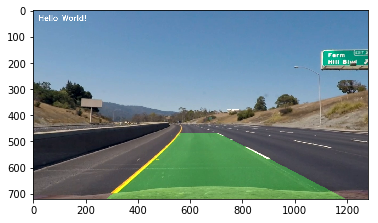

 40%|████      | 51/126 [00:19<00:27,  2.73it/s]

3344.9293199004983 21560.59831900521
1093.3789965268654 m 6886.166573018741 m
-1.8936867462332974
-1.725769505184803 m


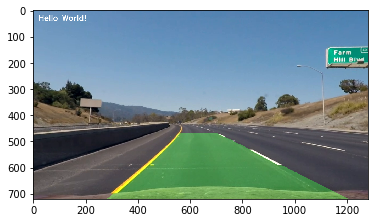

 41%|████▏     | 52/126 [00:19<00:26,  2.77it/s]

3637.2793244575387 277362.86187844985
1187.446728626282 m 88163.30438974318 m
-1.8937274514952813
-1.7181092149362898 m


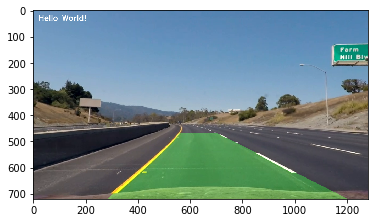

 42%|████▏     | 53/126 [00:19<00:25,  2.82it/s]

3884.326962880968 33737.65901114467
1266.3141410433607 m 10772.826018470609 m
-1.8937805074251948
-1.7081246625042261 m


KeyboardInterrupt: 

In [17]:
video_output = 'output.mp4'
video_input = 'project_video.mp4'

clip1 = VideoFileClip(video_input).subclip(0,5)
clip = clip1.fl_image(findLines) #NOTE: this function expects color images!!

%time clip.write_videofile(video_output, audio=False)
